# 07 – Null Model & Hypothesis Testing

This notebook compares the empirical Helsinki City Bikes network against three random null models to identify significant structural patterns. We test hypotheses related to flow corridors, spatial imbalance clustering, and centrality correlations.

## Null Models
1. **Erdős–Rényi (ER)**: Random graph with preserved $N$ (nodes) and $M$ (edges).
2. **Directed Configuration Model (DCM)**: Random graph preserving the exact in-degree and out-degree sequences.
3. **Degree-Preserving Edge Swaps (DPES)**: Randomized version of the real graph via iterative edge swapping (preserves degrees strictly and connectivity better than DCM).

## Hypotheses Tested
1. **Flow Corridors**: Does the real network have significantly stronger high-traffic routes (higher Gini coefficient of edge weights) than random?
2. **Imbalance Clustering**: Are station imbalances (Departures - Returns) spatially clustered (high Moran's I) compared to nulls?
3. **Centrality Correlations**: Is the correlation between global importance (PageRank) and brokerage potential (Betweenness) an emergent property?

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Resolve paths
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 'data').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PATH = PROJECT_ROOT / 'data' / '2021-04_cleaned.csv'

print(f"Data Path: {DATA_PATH}")

Data Path: c:\Users\sajay\Documents\Python\Network-Science---Helsinki-City-Bikes---UZH\Network-Science---Helsinki-City-Bikes---UZH\data\2021-04_cleaned.csv


## 1. Data Loading & Graph Construction

In [2]:
# Load Data
df = pd.read_csv(DATA_PATH)

# Aggregate to Edges
edge_df = (
    df.groupby(['Departure station id', 'Return station id'], as_index=False)
      .agg(trip_count=('Departure station id', 'size'))
)

# Create Station Metadata (Need coordinates for Moran's I)
stations_dep = df[['Departure station id', 'Departure station name', 'Departure_lat', 'Departure_lon']].drop_duplicates()
stations_dep.columns = ['id', 'name', 'lat', 'lon']

stations_ret = df[['Return station id', 'Return station name', 'Return_lat', 'Return_lon']].drop_duplicates()
stations_ret.columns = ['id', 'name', 'lat', 'lon']

stations = pd.concat([stations_dep, stations_ret]).drop_duplicates(subset='id').set_index('id')

# Construct Real Graph
G_real = nx.DiGraph()
for station_id, row in stations.iterrows():
    G_real.add_node(station_id, pos=(row['lon'], row['lat']), name=row['name'])

for _, row in edge_df.iterrows():
    G_real.add_edge(
        row['Departure station id'], 
        row['Return station id'], 
        weight=row['trip_count']
    )

print(f"Real Graph: {G_real.number_of_nodes()} nodes, {G_real.number_of_edges()} edges")

Real Graph: 351 nodes, 32815 edges


## 2. Metric Functions

We define the functions to calculate our three key metrics.

In [3]:
def calculate_gini(G):
    """Calculates the Gini coefficient of edge weights to measure flow concentration."""
    weights = sorted([d['weight'] for u, v, d in G.edges(data=True)])
    if not weights:
        return 0
    
    # Standard Gini calculation
    n = len(weights)
    numer = sum((i + 1) * w for i, w in enumerate(weights))
    denom = n * sum(weights)
    
    return (2 * numer) / denom - (n + 1) / n

def calculate_morans_i(G, stations_df):
    """
    Calculates Moran's I for station imbalance (In-Degree - Out-Degree).
    Uses Inverse Distance Weighting (IDW) for the spatial weights matrix.
    """
    # 1. Calculate Imbalance
    imbalances = {}
    for node in G.nodes():
        in_w = G.in_degree(node, weight='weight')
        out_w = G.out_degree(node, weight='weight')
        imbalances[node] = in_w - out_w
    
    # Extract values strictly aligned with matrix
    nodes = list(G.nodes())
    values = np.array([imbalances[n] for n in nodes])
    
    # 2. Build Distance Weight Matrix (Inverse Distance)
    coords = stations_df.loc[nodes, ['lat', 'lon']].values
    n_nodes = len(nodes)
    
    # Simple Euclidean approx is sufficient for local significance tests, 
    # but let's do a quick pairwise calculation
    # (degrees to meters approx: lat*111km, lon*cos(lat)*111km)
    # For simplicity/speed in null model loop, we use euclidean on coords
    # A more rigorous approach would use Haversine, but O(N^2) loop is slow.
    # Given Helsinki is small, Euclidean on lat/lon is perfectly monotonic with distance.
    
    dlat = coords[:, 0:1] - coords[:, 0:1].T
    dlon = coords[:, 1:2] - coords[:, 1:2].T
    dists = np.sqrt(dlat**2 + dlon**2)
    
    with np.errstate(divide='ignore'):
        weights = 1.0 / dists
    np.fill_diagonal(weights, 0)
    
    # Row-normalize weights
    row_sums = weights.sum(axis=1)
    weights = weights / row_sums[:, np.newaxis]
    
    # 3. Calculate Moran's I
    val_mean = np.mean(values)
    z = values - val_mean
    
    numerator = np.sum(weights * np.outer(z, z))
    denominator = np.sum(z**2)
    
    return numerator / denominator # (N/W term is 1 for row-normalized)

def calculate_centrality_correlation(G):
    """Spearman correlation between PageRank and Betweenness Centrality."""
    try:
        # Use unweighted for centrality to capture topological role
        # (Or weighted if we want flow-based role, usually topology is benchmark)
        # Let's use weighted for PageRank (flow) and unweighted for Betweenness (bridge)
        pr = nx.pagerank(G, weight='weight')
        bc = nx.betweenness_centrality(G, weight=None, k=50) # k=50 for speed approx if graph is large
    except:
        return np.nan
    
    s_pr = pd.Series(pr)
    s_bc = pd.Series(bc)
    
    return s_pr.corr(s_bc, method='spearman')

## 3. Null Model Generators

We implement the three null models. Note that for weighted analysis, we apply a **random shuffle of empirical weights** to the edges of the generated null graphs. This ensures we are testing the *structure* of connections, not the weight distribution itself.

In [4]:
EMPIRICAL_WEIGHTS = [d['weight'] for u, v, d in G_real.edges(data=True)]

def assign_random_weights(G, weight_pool):
    """Assigns weights randomly from the pool to the graph edges."""
    np.random.shuffle(weight_pool)
    for i, (u, v) in enumerate(G.edges()):
        G[u][v]['weight'] = weight_pool[i]
    return G

def generate_er(N, M, template_nodes):
    """Erdos-Renyi Random Graph"""
    G = nx.gnm_random_graph(N, M, directed=True)
    
    # Relabel nodes to match real IDs to keep coordinate mapping valid
    mapping = dict(zip(G.nodes(), template_nodes))
    G = nx.relabel_nodes(G, mapping)
    
    return G

def generate_dcm(in_seq, out_seq):
    """Directed Configuration Model"""
    # This creates a multigraph, we coerce to simple DiGraph
    G_multi = nx.directed_configuration_model(in_seq, out_seq, seed=None)
    G = nx.DiGraph(G_multi)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

def generate_dpes(G_start, n_swaps=10):
    """Degree-Preserving Edge Swaps"""
    G = G_start.copy()
    # weight='weight' parameter means weights are swapped WITH the edges, preserving strength??
    # No, usually double_edge_swap preserves degrees. Weights move with edges.
    # BUT: For null model comparison, we usually want to randomize weights separately 
    # OR distinct analysis: "weights coupled with topology".
    # Standard approach: shuffle weights globally after swapping to break weight-topology link.
    
    try:
        nx.double_edge_swap(G, nswap=n_swaps * G.number_of_edges(), max_tries=n_swaps * G.number_of_edges() * 5, seed=None)
    except nx.NetworkXError:
        pass # Sometimes fails if graph is too small/rigid
    return G

## 4. Simulation Loop

We run $N=100$ realizations for each model and collect metrics.

In [5]:
N_ITERS = 100
real_nodes = list(G_real.nodes())
N = G_real.number_of_nodes()
M = G_real.number_of_edges()
in_degree_seq = [d for n, d in G_real.in_degree()]
out_degree_seq = [d for n, d in G_real.out_degree()]

# Store results
results = {
    'Model': [],
    'Gini': [],
    'Morans_I': [],
    'Centr_Corr': []
}

# 1. Real Network Metrics
real_gini = calculate_gini(G_real)
real_moran = calculate_morans_i(G_real, stations)
real_corr = calculate_centrality_correlation(G_real)

results['Model'].append('Real')
results['Gini'].append(real_gini)
results['Morans_I'].append(real_moran)
results['Centr_Corr'].append(real_corr)

print(f"Real Network: Gini={real_gini:.3f}, Moran={real_moran:.3f}, Corr={real_corr:.3f}")

# 2. Run Nulls
for _ in tqdm(range(N_ITERS), desc="Simulating Nulls"):
    # -- Erdős–Rényi --
    G_er = generate_er(N, M, real_nodes)
    G_er = assign_random_weights(G_er, EMPIRICAL_WEIGHTS.copy())
    results['Model'].append('ER')
    results['Gini'].append(calculate_gini(G_er))
    results['Morans_I'].append(calculate_morans_i(G_er, stations))
    results['Centr_Corr'].append(calculate_centrality_correlation(G_er))
    
    # -- Directed Config --
    G_dcm = generate_dcm(in_degree_seq, out_degree_seq)
    # DCM creates new int nodes 0..N-1. Map back to real IDs randomly or meaningfully?
    # Random mapping is fine since DCM destroys local spatial correlations anyway.
    mapping_dcm = dict(zip(G_dcm.nodes(), real_nodes))
    G_dcm = nx.relabel_nodes(G_dcm, mapping_dcm)
    G_dcm = assign_random_weights(G_dcm, EMPIRICAL_WEIGHTS.copy())
    results['Model'].append('DCM')
    results['Gini'].append(calculate_gini(G_dcm))
    results['Morans_I'].append(calculate_morans_i(G_dcm, stations))
    results['Centr_Corr'].append(calculate_centrality_correlation(G_dcm))
    
    # -- Edge Swaps --
    G_dpes = generate_dpes(G_real, n_swaps=1)
    # Shuffle weights because we want to test if *specific* links matter, not just degree-weight correlations
    G_dpes = assign_random_weights(G_dpes, EMPIRICAL_WEIGHTS.copy())
    results['Model'].append('DPES')
    results['Gini'].append(calculate_gini(G_dpes))
    results['Morans_I'].append(calculate_morans_i(G_dpes, stations))
    results['Centr_Corr'].append(calculate_centrality_correlation(G_dpes))

res_df = pd.DataFrame(results)

Real Network: Gini=0.617, Moran=0.036, Corr=0.717


Simulating Nulls:   0

Simulating Nulls:   1

Simulating Nulls:   2

Simulating Nulls:   3

Simulating Nulls:   4

Simulating Nulls:   5

Simulating Nulls:   6

Simulating Nulls:   7

Simulating Nulls:   8

Simulating Nulls:   9

Simulating Nulls:  10

Simulating Nulls:  11

Simulating Nulls:  12

Simulating Nulls:  13

Simulating Nulls:  14

Simulating Nulls:  15

Simulating Nulls:  16

Simulating Nulls:  17

Simulating Nulls:  18

Simulating Nulls:  19

Simulating Nulls:  20

Simulating Nulls:  21

Simulating Nulls:  22

Simulating Nulls:  23

Simulating Nulls:  24

Simulating Nulls:  25

Simulating Nulls:  26

Simulating Nulls:  27

Simulating Nulls:  28

Simulating Nulls:  29

Simulating Nulls:  30

Simulating Nulls:  31

Simulating Nulls:  32

Simulating Nulls:  33

Simulating Nulls:  34

Simulating Nulls:  35

Simulating Nulls:  36

Simulating Nulls:  37

Simulating Nulls:  38

Simulating Nulls:  39

Simulating Nulls:  40

Simulating Nulls:  41

Simulating Nulls:  42

Simulating Nulls:  43

Simulating Nulls:  44

Simulating Nulls:  45

Simulating Nulls:  46

Simulating Nulls:  47

Simulating Nulls:  48

Simulating Nulls:  49

Simulating Nulls:  50

Simulating Nulls:  51

Simulating Nulls:  52

Simulating Nulls:  53

Simulating Nulls:  54

Simulating Nulls:  55

Simulating Nulls:  56

Simulating Nulls:  57

Simulating Nulls:  58

Simulating Nulls:  59

Simulating Nulls:  60

Simulating Nulls:  61

Simulating Nulls:  62

Simulating Nulls:  63

Simulating Nulls:  64

Simulating Nulls:  65

Simulating Nulls:  66

Simulating Nulls:  67

Simulating Nulls:  68

Simulating Nulls:  69

Simulating Nulls:  70

Simulating Nulls:  71

Simulating Nulls:  72

Simulating Nulls:  73

Simulating Nulls:  74

Simulating Nulls:  75

Simulating Nulls:  76

Simulating Nulls:  77

Simulating Nulls:  78

Simulating Nulls:  79

Simulating Nulls:  80

Simulating Nulls:  81

Simulating Nulls:  82

Simulating Nulls:  83

Simulating Nulls:  84

Simulating Nulls:  85

Simulating Nulls:  86

Simulating Nulls:  87

Simulating Nulls:  88

Simulating Nulls:  89

Simulating Nulls:  90

Simulating Nulls:  91

Simulating Nulls:  92

Simulating Nulls:  93

Simulating Nulls:  94

Simulating Nulls:  95

Simulating Nulls:  96

Simulating Nulls:  97

Simulating Nulls:  98

Simulating Nulls:  99

Simulating Nulls: 100

Simulating Nulls: 100

## 5. Statistical Analysis & Visualization

We calculate Z-scores ($Z = \frac{X_{real} - \mu_{null}}{\sigma_{null}}$) and visualize the distributions.

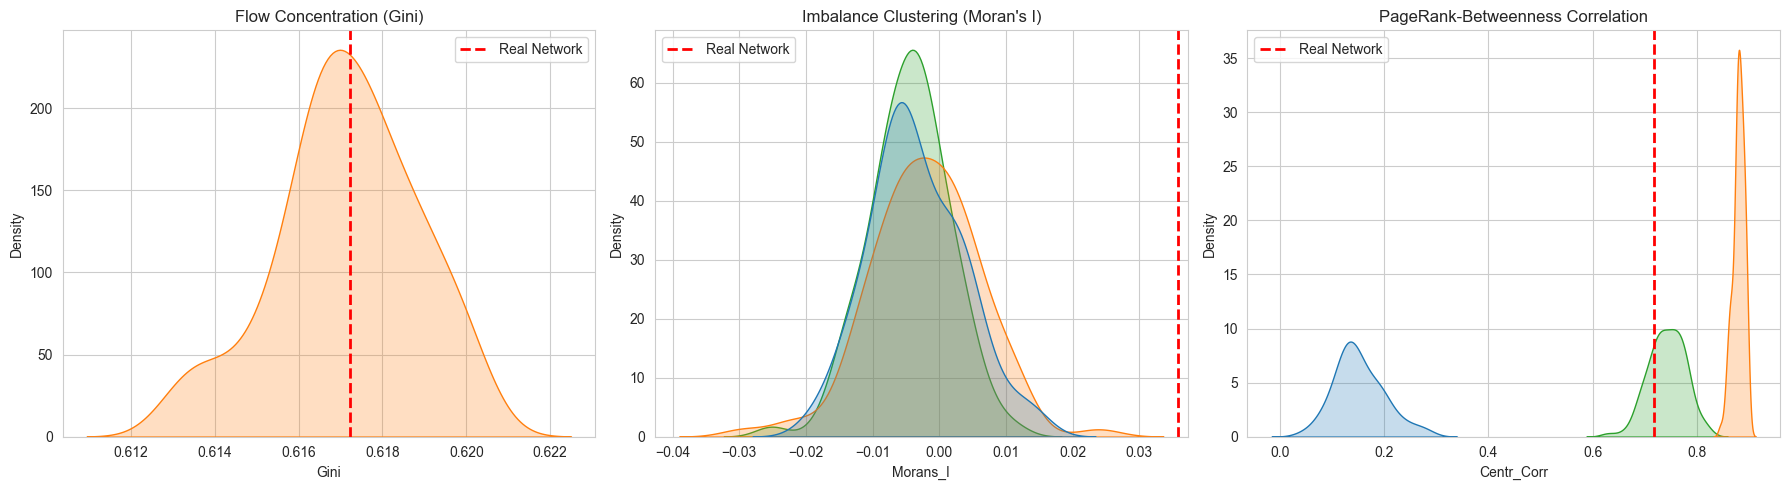

In [6]:
def plot_comparison(metric_col, title, ax):
    sns.kdeplot(data=res_df[res_df['Model']!='Real'], x=metric_col, hue='Model', fill=True, ax=ax, common_norm=False)
    real_val = res_df[res_df['Model']=='Real'][metric_col].values[0]
    ax.axvline(real_val, color='red', linestyle='--', linewidth=2, label='Real Network')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_comparison('Gini', 'Flow Concentration (Gini)', axes[0])
plot_comparison('Morans_I', 'Imbalance Clustering (Moran\'s I)', axes[1])
plot_comparison('Centr_Corr', 'PageRank-Betweenness Correlation', axes[2])

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'data' / 'null_model_comparison_plots.png')
plt.show()

In [7]:
# Calculate Z-scores and P-values
stats_rows = []

for model in ['ER', 'DCM', 'DPES']:
    null_data = res_df[res_df['Model'] == model]
    
    for metric in ['Gini', 'Morans_I', 'Centr_Corr']:
        real_val = res_df[res_df['Model']=='Real'][metric].values[0]
        null_vals = null_data[metric].values
        
        mean = np.mean(null_vals)
        std = np.std(null_vals)
        
        z_score = (real_val - mean) / std if std > 0 else 0
        # One-tailed p-value (approximate from distribution or simple count)
        # If real >> null, p = count(null > real) / N
        # If real << null, p = count(null < real) / N
        # We'll use 2-tailed for generality
        p_val_count = min((null_vals >= real_val).mean(), (null_vals <= real_val).mean()) * 2
        
        stats_rows.append({
            'Comparison': f'Real vs {model}',
            'Metric': metric,
            'Real Value': real_val,
            'Null Mean': mean,
            'Z-Score': z_score,
            'P-Value': max(p_val_count, 1/N_ITERS) # Floor p-value at resolution
        })

stats_df = pd.DataFrame(stats_rows)
stats_df.round(3)

,Comparison,Metric,Real Value,Null Mean,Z-Score,P-Value
0,Real vs ER,Gini,0.617,0.617,0.000,2.00
1,Real vs ER,Morans_I,0.036,-0.003,5.593,0.01
2,Real vs ER,Centr_Corr,0.717,0.153,11.802,0.01
3,Real vs DCM,Gini,0.617,0.617,0.047,1.00
4,Real vs DCM,Morans_I,0.036,-0.002,4.679,0.01
5,Real vs DCM,Centr_Corr,0.717,0.879,-14.594,0.01
6,Real vs DPES,Gini,0.617,0.617,0.000,2.00
7,Real vs DPES,Morans_I,0.036,-0.005,6.729,0.01
8,Real vs DPES,Centr_Corr,0.717,0.741,-0.686,0.48


In [8]:
# Export Statistics to CSV
output_stat_path = PROJECT_ROOT / 'data' / 'null_model_stats.csv'
stats_df.to_csv(output_stat_path, index=False)
print(f"Statistics saved to {output_stat_path}")
stats_df

Statistics saved to c:\Users\sajay\Documents\Python\Network-Science---Helsinki-City-Bikes---UZH\Network-Science---Helsinki-City-Bikes---UZH\data\null_model_stats.csv


,Comparison,Metric,Real Value,Null Mean,Z-Score,P-Value
0,Real vs ER,Gini,0.617223,0.617223,0.000000,2.00
1,Real vs ER,Morans_I,0.035748,-0.003465,5.592756,0.01
2,Real vs ER,Centr_Corr,0.717262,0.152557,11.801842,0.01
3,Real vs DCM,Gini,0.617223,0.617145,0.046702,1.00
4,Real vs DCM,Morans_I,0.035748,-0.002110,4.679375,0.01
5,Real vs DCM,Centr_Corr,0.717262,0.878617,-14.594135,0.01
6,Real vs DPES,Gini,0.617223,0.617223,0.000000,2.00
7,Real vs DPES,Morans_I,0.035748,-0.004546,6.729459,0.01
8,Real vs DPES,Centr_Corr,0.717262,0.741082,-0.685883,0.48


## 6. Spatial Variation Maps

To better understand the statistical results, we visualize the spatial differences between the Real Network and a Random (Erdős–Rényi) realization.

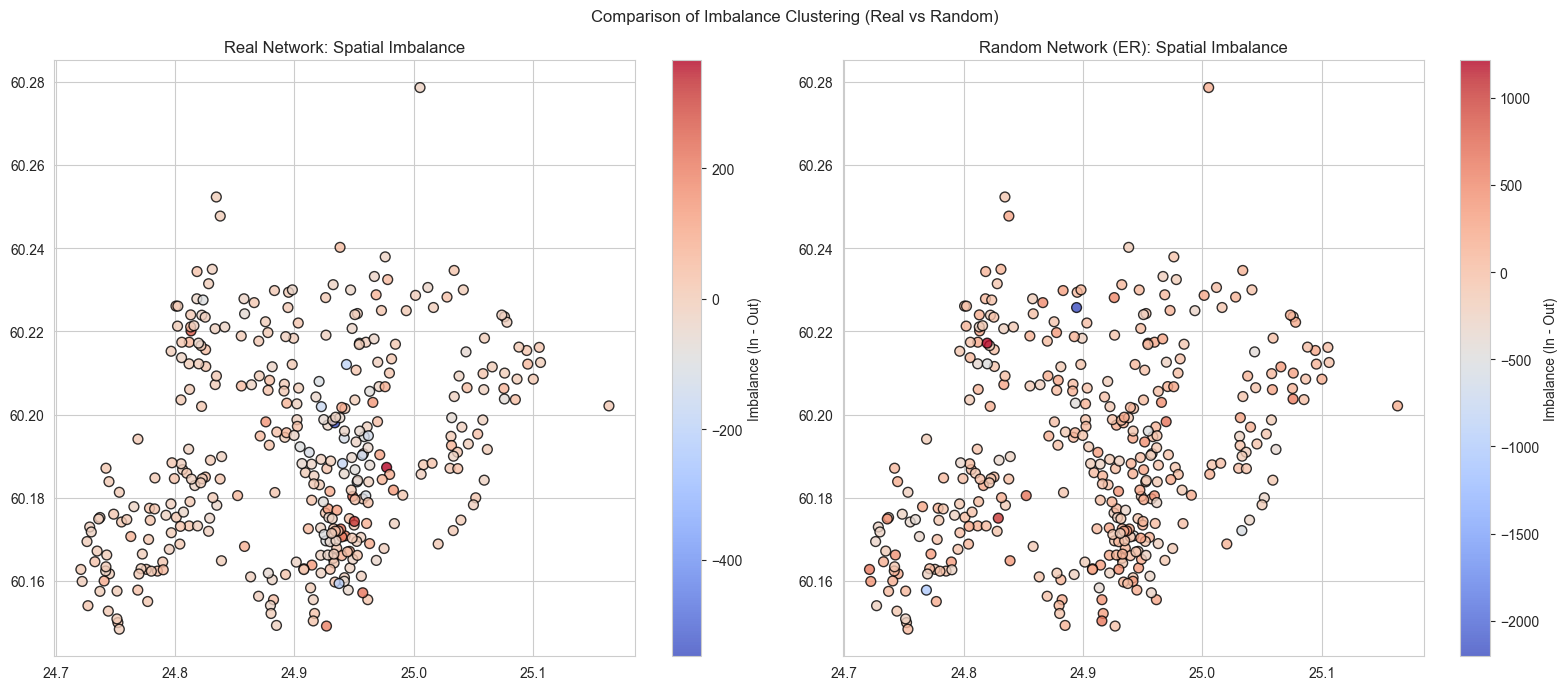

In [9]:
def get_imbalance(G):
    imbalances = {}
    for node in G.nodes():
        in_w = G.in_degree(node, weight='weight')
        out_w = G.out_degree(node, weight='weight')
        imbalances[node] = in_w - out_w
    return imbalances

# Get one Random Graph for visual comparison
G_random_vis = generate_er(N, M, real_nodes)
G_random_vis = assign_random_weights(G_random_vis, EMPIRICAL_WEIGHTS.copy())

real_imbalance = get_imbalance(G_real)
rand_imbalance = get_imbalance(G_random_vis)

# Setup Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot Real Imbalance
sc1 = axes[0].scatter(
    stations.loc[real_nodes, 'lon'], 
    stations.loc[real_nodes, 'lat'],
    c=[real_imbalance[n] for n in real_nodes],
    cmap='coolwarm',
    s=50,
    alpha=0.8,
    edgecolor='k'
)
axes[0].set_title("Real Network: Spatial Imbalance")
plt.colorbar(sc1, ax=axes[0], label='Imbalance (In - Out)')

# Plot Random Imbalance
sc2 = axes[1].scatter(
    stations.loc[real_nodes, 'lon'], 
    stations.loc[real_nodes, 'lat'],
    c=[rand_imbalance[n] for n in real_nodes] if real_nodes else [],
    cmap='coolwarm',
    s=50,
    alpha=0.8,
    edgecolor='k'
)
axes[1].set_title("Random Network (ER): Spatial Imbalance")
plt.colorbar(sc2, ax=axes[1], label='Imbalance (In - Out)')

plt.suptitle("Comparison of Imbalance Clustering (Real vs Random)")
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'data' / 'imbalance_comparison_map.png')
plt.show()

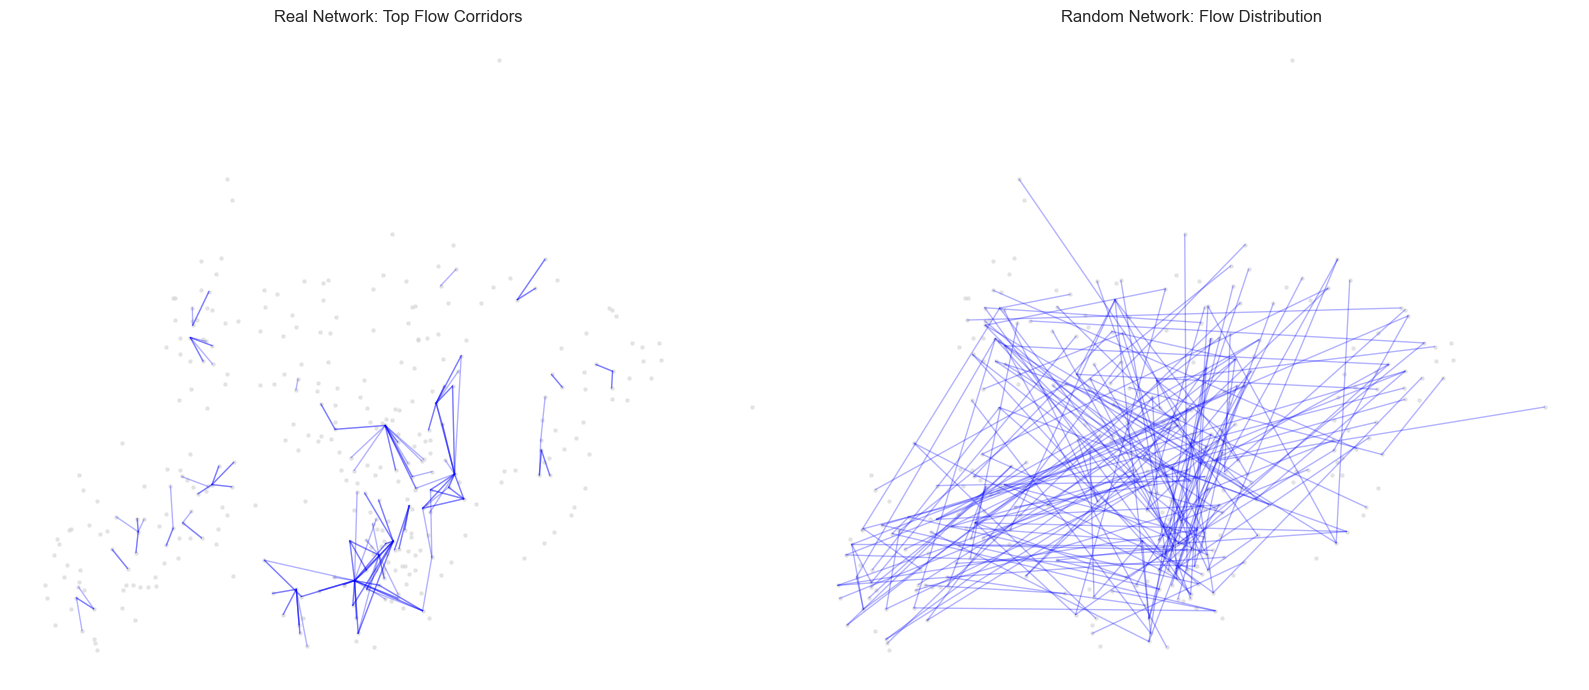

In [10]:
def plot_top_edges(G, ax, title, top_k=200):
    edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:top_k]
    
    # Plot nodes locally
    ax.scatter(
        stations.loc[real_nodes, 'lon'], 
        stations.loc[real_nodes, 'lat'],
        c='lightgrey', s=5, alpha=0.5
    )
    
    # Plot edges
    for u, v, d in edges:
        try:
            x_vals = [stations.loc[u, 'lon'], stations.loc[v, 'lon']]
            y_vals = [stations.loc[u, 'lat'], stations.loc[v, 'lat']]
            alpha = min(1.0, d['weight'] / 500) # Simple scaling for visibility
            ax.plot(x_vals, y_vals, c='blue', alpha=0.3, linewidth=1)
        except KeyError:
            pass
    ax.set_title(title)
    ax.axis('off')

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
plot_top_edges(G_real, axes[0], "Real Network: Top Flow Corridors")
plot_top_edges(G_random_vis, axes[1], "Random Network: Flow Distribution")

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'data' / 'flow_comparison_map.png')
plt.show()